In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import random
import cv2
import time
import torch.optim as optim
from tensorboardX import SummaryWriter

import torchvision.utils as vutils
from torchvision import datasets
from torchvision.transforms import ToTensor


datasize:   202599    #
epochs:     10000     #
batch_size: 256       #
lr:         1e-06     #
z_size:     100       #
num_batch:  791       #



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("torch version:", torch.__version__)
print("device:", device)
batch_size = 64
# Model
z_size = 100
class_num = 10
# Training
epochs = 1
learning_rate = 3e-4
GEN_FILTERS = 64
DIS_FILTERS = 64
transform = transforms.Compose([
    ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5))
])
# Load Dataset
training_data = datasets.MNIST(root="data",
                               train=True,
                               transform=transform)
class_num = 10
data_loader = DataLoader(training_data,
                         batch_size,
                         drop_last=True)

torch version: 1.10.1+cu111
device: cuda


In [35]:
class Generator(nn.Module):
    def __init__(self, z_size, class_num):
        super(Generator, self).__init__()
        
        self.z_size = z_size
        
        
        self.model = nn.Sequential(
            # block 1 [N, 110, 1, 1] --> [N, 256, 7, 7]
            nn.ConvTranspose2d(
                in_channels=z_size+class_num,
                out_channels=GEN_FILTERS * 4,
                kernel_size=7,
                stride=2,
                padding=0
            ),
            nn.BatchNorm2d(GEN_FILTERS * 4),
            nn.ReLU(),
            # block 1 [N, 256, 7, 7] --> [N, 128, 14, 14]
            nn.ConvTranspose2d(
                in_channels=GEN_FILTERS * 4,
                out_channels=GEN_FILTERS * 2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(GEN_FILTERS * 2),
            nn.ReLU(),
            # block 1 [N, 128, 14, 14] --> [N, 1, 28, 28]
            nn.ConvTranspose2d(
                in_channels=GEN_FILTERS * 2,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.Tanh()
    )
    
    def forward(self, z, labels):
        # z.shape --> N, 100, 1, 1
        # labels reshape
        c = labels.unsqueeze(-1).unsqueeze(-1)
        # N, 10, 1, 1
        # Concat image & labels
        x = torch.cat([z, c], 1)
        # N, 110, 1, 1
        # Generator out
        out = self.model(x)
        
        return out

In [36]:
class Discriminator(nn.Module):
    def __init__(self, class_num, kernel_size=5):
        super(Discriminator, self).__init__()
        
        self.model_1 = nn.Sequential(
            # block 1
            nn.Conv2d(
                in_channels=1,
                out_channels=DIS_FILTERS,
                kernel_size=kernel_size,
                stride=1,
                padding=2
            ),
            nn.ReLU()
        )
        self.model_2 = nn.Sequential(
            # block 2
            nn.Conv2d(
                in_channels=DIS_FILTERS+class_num,
                out_channels=DIS_FILTERS*2,
                kernel_size=kernel_size,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(DIS_FILTERS*2),
            nn.ReLU(),
            # block 3
            nn.Conv2d(
                in_channels=DIS_FILTERS * 2,
                out_channels=DIS_FILTERS * 4,
                kernel_size=kernel_size,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(DIS_FILTERS * 4),
            nn.ReLU(),
            # block 4
            nn.Conv2d(
                in_channels=DIS_FILTERS * 4,
                out_channels=1,
                kernel_size=kernel_size,
                stride=7,
                padding=1
            ),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = self.model_1(x)
        # N, 64, 28, 28
        # Reshape labels
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        c = torch.tile(labels, [1, 1, 28, 28])
        # N, 64, 28, 28
        # Concat image & label
        x = torch.cat([x, c], 1)
        # N, 74, 28, 28
        # Discriminator output
        out = self.model_2(x)
        # N, 1, 1, 1
        return out.squeeze()

In [37]:
dis = Discriminator(class_num).to(device)
gen = Generator(z_size, class_num).to(device)

objective = nn.BCELoss()
gen_opt = optim.Adam(params=gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
dis_opt = optim.Adam(params=dis.parameters(), lr=learning_rate, betas=(0.5, 0.999))
dis_opt = optim.Adam(params=dis.parameters(), lr=learning_rate, betas=(0.5, 0.999))
writer = SummaryWriter(log_dir="test_04")

gen_losses = []
dis_losses = []
iter_no = 0

true_labels = torch.ones(batch_size, dtype=torch.float32, device=device)
fake_labels = torch.zeros(batch_size, dtype=torch.float32, device=device)
num_batch = len(data_loader)

In [38]:
for epoch in range(epochs):
    start_time = time.time()
    for X, Y in data_loader:
        iter_no += 1
        
        # generate extra faka samples: batch, filters, x, y
        gen_input = torch.FloatTensor(batch_size, z_size, 1, 1).normal_(0, 1).to(device)
        batch = X.to(device)
        y_batch = nn.functional.one_hot(Y).to(device)
        gen_output = gen(gen_input, y_batch)
        
        # train discriminator
        dis_opt.zero_grad()
        dis_output_true = dis(batch, y_batch)
        dis_output_fake = dis(gen_output.detach(), y_batch)
        dis_loss = objective(dis_output_true, true_labels) + objective(dis_output_fake, fake_labels)
        dis_loss.backward()
        dis_opt.step()
        dis_losses.append(dis_loss.item())
        
        # train generator
        gen_opt.zero_grad()
        dis_output = dis(gen_output, y_batch)
        gen_loss = objective(dis_output, true_labels)
        gen_loss.backward()
        gen_opt.step()
        gen_losses.append(gen_loss.item())
        
        print(f"Epoch: {epoch+1:02d}/{epochs}    iter: {iter_no%num_batch}/{num_batch}    dis_loss: {np.mean(dis_losses):.5f}    gen_loss: {np.mean(gen_losses):.5f}    T: {time.time() - start_time:.3f} s", end="\r")
        writer.add_scalar("gen_loss", np.mean(gen_losses), iter_no)
        writer.add_scalar("dis_loss", np.mean(dis_losses), iter_no)
    writer.add_image("fake", vutils.make_grid(gen_output.data[:32], normalize=True), epoch+1)
    writer.add_image("real", vutils.make_grid(batch.data[:32], normalize=True), epoch+1)

  0.01 +/-   1.00
 -0.00 +/-   0.80
  0.23 +/-   0.33
  0.55 +/-   0.06
  0.18 +/-   0.26
  0.54 +/-   0.06
  0.18 +/-   0.26
  0.29 +/-   0.05


/tmp/ipykernel_358831/2833528795.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(x, dtype=torch.float32)


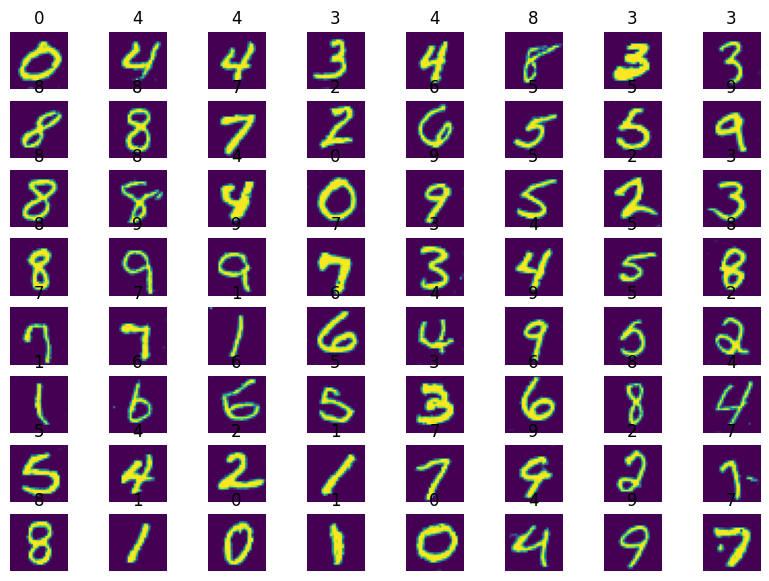

In [70]:
nums = torch.randint(0, 10, (64,))
labels = nn.functional.one_hot(nums).to(device)
input_noise = torch.FloatTensor(64, 100, 1, 1).normal_(0, 1).to(device)
out_ = gen(input_noise, labels)
fig = plt.figure(figsize=(10, 7))
for i, img in enumerate(out_):
#     print(i)
#     print(type(img), img[0].shape)
#     break
    fig.add_subplot(8, 8, i+1)
    plt.imshow(img[0].cpu().data.numpy())
    plt.axis('off')
    plt.title(f"{nums[i]}")

In [72]:
torch.save(gen.state_dict(), "generator.pt")
torch.save(dis.state_dict(), "discriminator.pt")
# # Save:
# torch.save(old_model.state_dict(), PATH)

# # Load:
# new_model = TheModelClass(*args, **kwargs)
# new_model.load_state_dict(torch.load(PATH))